In [1]:
import glob 
import pandas as pd
import numpy as np

exclude_perc_threshold = 0.5

no_timepoint_excluded = pd.read_excel("/mnt/LABS/tbi/implicitmem_SCI/code/feat_lev1/all_03.xlsx")
run_excluded = no_timepoint_excluded.loc[no_timepoint_excluded.exclude_perc >= exclude_perc_threshold]

run_excluded = run_excluded.assign(subjectid = run_excluded['input'].apply(lambda x: x.split('_')[0]))
run_excluded = run_excluded.assign(runid = run_excluded['input'].apply(lambda x: x.split('_')[2]))
run_excluded = run_excluded.assign(featdir = run_excluded['subjectid'] + '_' + run_excluded['runid'])



derivatives = '/mnt/LABS/tbi/implicitmem_SCI/derivatives/'
highpass = '100'
cope = 'cope4'
niimgs = sorted(glob.glob(derivatives + 'feat_lev1_hp' + highpass + 
                                 '/sub-*_run-2' + '.feat/stats/' + cope + '.nii.gz'))
niimgs_fin = list(filter(lambda filename: 
                         filename.split('/')[7].split('_')[0] not in np.unique(run_excluded['subjectid']), niimgs))
group = [0 if 'HC' in nii_name else 1 for nii_name in niimgs]
len(group)

53

In [2]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 10

In [3]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(group)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

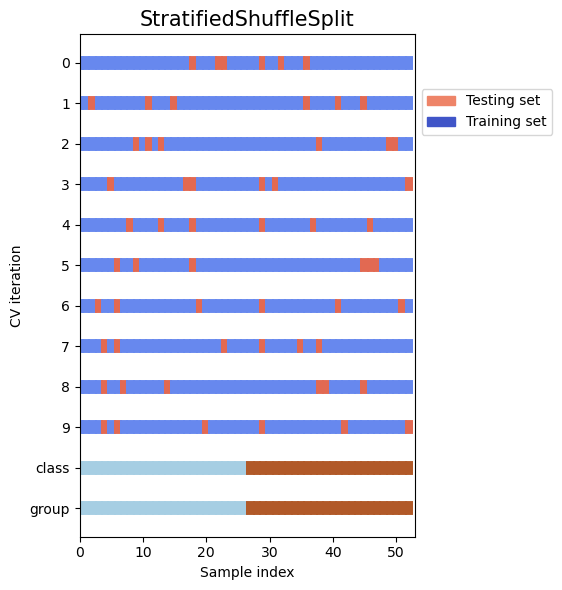

In [4]:
cvs = [StratifiedShuffleSplit]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_cv_indices(cv(n_splits), niimgs, np.array(group), group, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)